# VAE
## 4.1: Training the VAE

In [4]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from architecture import VAE
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

latent_dim = 20
batch_size = 128
epochs = 20
lr = 1e-3
kl_weight = 5.0  # high weight to induce posterior collapse

# dataset
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# model
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)


In [3]:
def vae_loss(recon_x, x, mu, logvar, kl_weight=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = recon_loss + kl_weight * kl_loss
    return total_loss, recon_loss, kl_loss

# Training
train_losses, val_losses = [], []
train_recon_losses, val_recon_losses = [], []
train_kl_losses, val_kl_losses = [], []

for epoch in range(1, epochs+1):
    model.train()
    train_loss = train_recon = train_kl = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)
        loss, recon_l, kl_l = vae_loss(recon_x, x, mu, logvar, kl_weight=kl_weight)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_recon += recon_l.item()
        train_kl += kl_l.item()
    train_losses.append(train_loss / len(train_dataset))
    train_recon_losses.append(train_recon / len(train_dataset))
    train_kl_losses.append(train_kl / len(train_dataset))

    # Validation
    model.eval()
    val_loss = val_recon = val_kl = 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            loss, recon_l, kl_l = vae_loss(recon_x, x, mu, logvar, kl_weight=kl_weight)
            val_loss += loss.item()
            val_recon += recon_l.item()
            val_kl += kl_l.item()
    val_losses.append(val_loss / len(test_dataset))
    val_recon_losses.append(val_recon / len(test_dataset))
    val_kl_losses.append(val_kl / len(test_dataset))

    print(f"Epoch [{epoch}/{epochs}] | "
          f"Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | "
          f"Recon: {train_recon_losses[-1]:.4f} | KL: {train_kl_losses[-1]:.4f}")

# Plot ELBO components
plt.figure(figsize=(8,5))
plt.plot(train_recon_losses, label="Reconstruction Loss")
plt.plot(train_kl_losses, label="KL Divergence")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ELBO Components (Training)")
plt.legend()
plt.show()



Epoch [1/20] | Train Loss: 54.1333 | Val Loss: 45.4444 | Recon: 45.6527 | KL: 1.6961
Epoch [2/20] | Train Loss: 44.4801 | Val Loss: 43.7248 | Recon: 31.9026 | KL: 2.5155
Epoch [3/20] | Train Loss: 43.5567 | Val Loss: 43.1002 | Recon: 29.9873 | KL: 2.7139
Epoch [4/20] | Train Loss: 43.0556 | Val Loss: 42.8473 | Recon: 29.1360 | KL: 2.7839
Epoch [5/20] | Train Loss: 42.7925 | Val Loss: 42.5005 | Recon: 28.5524 | KL: 2.8480
Epoch [6/20] | Train Loss: 42.5241 | Val Loss: 42.4410 | Recon: 28.2138 | KL: 2.8621
Epoch [7/20] | Train Loss: 42.4856 | Val Loss: 42.2712 | Recon: 27.9626 | KL: 2.9046
Epoch [8/20] | Train Loss: 42.4077 | Val Loss: 42.4028 | Recon: 27.8011 | KL: 2.9213
Epoch [9/20] | Train Loss: 42.2760 | Val Loss: 42.1679 | Recon: 27.5357 | KL: 2.9481
Epoch [10/20] | Train Loss: 42.1991 | Val Loss: 42.3735 | Recon: 27.4639 | KL: 2.9470
Epoch [11/20] | Train Loss: 42.1388 | Val Loss: 42.0455 | Recon: 27.3718 | KL: 2.9534
Epoch [12/20] | Train Loss: 42.1478 | Val Loss: 42.3274 | Recon

NameError: name 'plt' is not defined

In [36]:
# After training
torch.save(model.state_dict(), "vae_fashionmnist.pth")


## Task 4.2: visualizing reconstructions and generations,

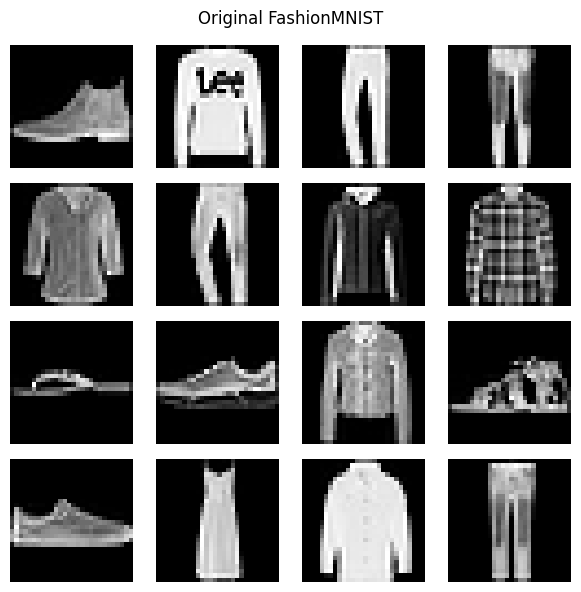

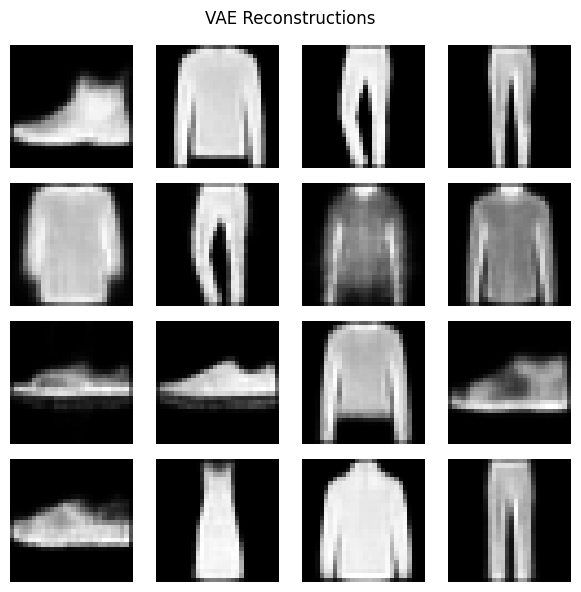

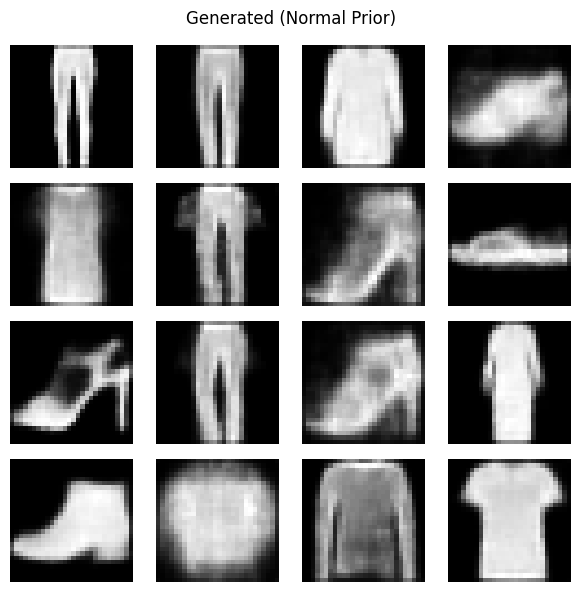

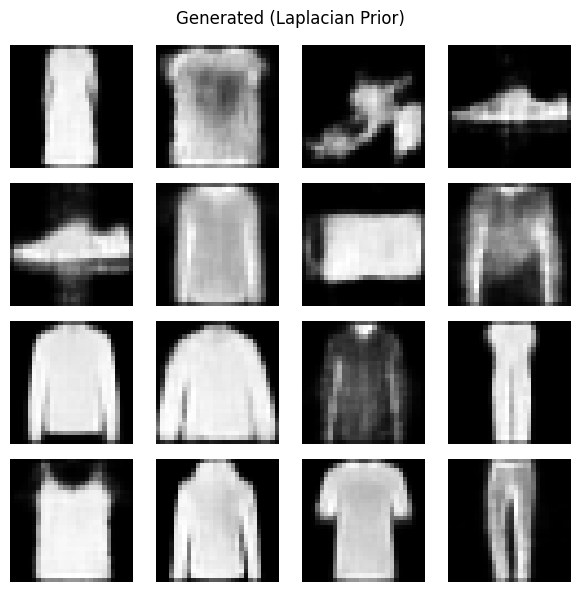

In [39]:
import matplotlib.pyplot as plt
import torch

vae.eval()
device = next(vae.parameters()).device

# Fetch a batch of test images
data_iter = iter(test_loader)
x, _ = next(data_iter)
x = x.to(device)

# Reconstruct
with torch.no_grad():
    recon, mu, logvar = vae(x)

# Generate from standard Normal prior
z = torch.randn(16, vae.fc_mu.out_features).to(device)
with torch.no_grad():
    gen_normal = vae.decode(z)

# Generate from Laplacian prior
z_lap = torch.distributions.Laplace(0,1).sample((16, vae.fc_mu.out_features)).to(device)
with torch.no_grad():
    gen_laplace = vae.decode(z_lap)

# Plot 4x4 grid function
def plot_images(images, title, filename):
    images = images.cpu()
    fig, axes = plt.subplots(4,4, figsize=(6,6))
    for i, ax in enumerate(axes.flatten()):
        if i >= images.size(0):
            ax.axis('off')
            continue
        ax.imshow(images[i,0], cmap='gray')
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

plot_images(x[:16], "Original FashionMNIST", "original.png")
plot_images(recon[:16], "VAE Reconstructions", "vae_recon.png")
plot_images(gen_normal, "Generated (Normal Prior)", "prior_recon.png")
plot_images(gen_laplace, "Generated (Laplacian Prior)", "laplacian_prior.png")


## 4.3: Analysing ELBO components

In [40]:
import torch.nn.functional as F

# record ELBO components
train_recon_losses = []
train_kl_losses = []

for x, _ in train_loader: # Unpack the tuple
    x = x.to(device)
    recon, mu, logvar = vae(x)

    recon_loss = F.mse_loss(recon, x, reduction='sum') / x.size(0)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)

    train_recon_losses.append(recon_loss.item())
    train_kl_losses.append(kl_loss.item())

print("Final recon loss:", train_recon_losses[-1])
print("Final KL loss:", train_kl_losses[-1])

Final recon loss: 14.393192291259766
Final KL loss: 8.372230529785156


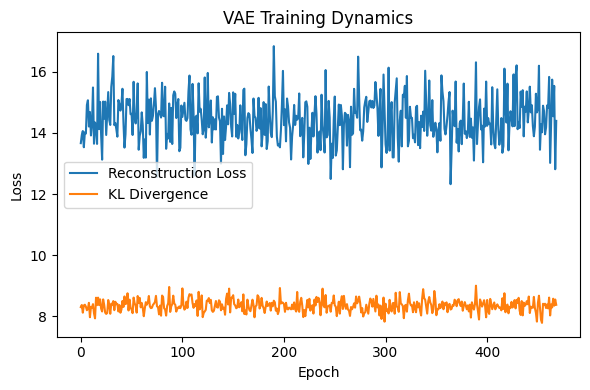

In [41]:
import matplotlib.pyplot as plt

# Suppose these are lists of losses per epoch
recon_losses = train_recon_losses  # append recon loss per epoch
kl_losses = train_kl_losses     # append KL divergence per epoch

plt.figure(figsize=(6,4))
plt.plot(recon_losses, label='Reconstruction Loss')
plt.plot(kl_losses, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Dynamics')
plt.legend()
plt.tight_layout()
plt.savefig('elbo_plot.png')
plt.show()


## 4.4: Mitigating Strategy

### KL Annealing

Gradually increase the weight of the KL term during training. Early on, reconstruction dominates, allowing the encoder to learn meaningful representations. Later, the KL term slowly regularizes the latent space.

Mathematically:

𝐿 =
Reconstruction Loss + 𝛽(𝑡)⋅KL Divergence

Where
𝛽(𝑡)
β(t) starts small (e.g., 0) and linearly grows to 1 over a number of epochs.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# KL annealing function
def kl_anneal(epoch, total_epochs, ramp_fraction=0.5):
    """Beta ramps from 0 → 1 over ramp_fraction of total epochs"""
    max_ramp_epoch = int(total_epochs * ramp_fraction)
    beta = min(1.0, epoch / max_ramp_epoch)
    return beta

# Training loop with KL scaling + free bits
train_losses, val_losses = [], []
recon_losses, kl_losses = [], []

epochs = 20  # adjust if needed
free_bits = 0.1  # minimum KL per latent dim to prevent collapse
kl_scale = 5.0   # scale KL relative to recon loss

model.to(device)

for epoch in range(1, epochs + 1):
    model.train()
    train_loss, recon_loss_epoch, kl_loss_epoch = 0, 0, 0
    beta = kl_anneal(epoch, epochs)

    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()

        recon_x, mu, logvar = model(x)

        # Reconstruction loss (sum over batch pixels)
        recon_l = nn.functional.mse_loss(recon_x, x, reduction='sum')

        # KL divergence (sum over latent dims)
        kl_l = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Apply free bits per latent dim
        kl_l = torch.clamp(kl_l, min=free_bits * mu.size(1) * x.size(0))

        # Total loss with scaled KL and annealing
        loss = recon_l + beta * kl_scale * kl_l
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        recon_loss_epoch += recon_l.item()
        kl_loss_epoch += kl_l.item()

    # Average per sample
    train_losses.append(train_loss / len(train_dataset))
    recon_losses.append(recon_loss_epoch / len(train_dataset))
    kl_losses.append(kl_loss_epoch / len(train_dataset))

    # Validation
    model.eval()
    val_loss, val_recon, val_kl = 0, 0, 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            recon_l = nn.functional.mse_loss(recon_x, x, reduction='sum')
            kl_l = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            kl_l = torch.clamp(kl_l, min=free_bits * mu.size(1) * x.size(0))
            val_loss += (recon_l + beta * kl_scale * kl_l).item()
            val_recon += recon_l.item()
            val_kl += kl_l.item()
    val_losses.append(val_loss / len(test_dataset))

    print(f"Epoch [{epoch}/{epochs}] | "
          f"Train Loss: {train_losses[-1]:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f} | "
          f"Recon: {recon_losses[-1]/len(train_dataset):.4f} | "
          f"KL: {kl_losses[-1]/len(train_dataset):.4f} | "
          f"Beta: {beta:.2f}")


Epoch [1/20] | Train Loss: 21.3938 | Val Loss: 20.7488 | Recon: 0.0003 | KL: 0.0001 | Beta: 0.10
Epoch [2/20] | Train Loss: 24.2976 | Val Loss: 24.2812 | Recon: 0.0003 | KL: 0.0001 | Beta: 0.20
